<h1 style="font-size: 30px;">
    AI generated text detector.
</h1>
<p style="font-size: 16px;">
    In this project i will implement a model that can predict whether a text is AI generated or not.<br>
    For this purpose, im going to create two different models, SVM and fine-tuning Distilbert model<br>
    Then for the final prediction i will use Stack method.<br>
</p>


# Importing the required libraries and Text preprocessing Steps
<p style="font-size: 18px;">
    - Since the dataset from the competition is a lot unbalanced, im getting help from three other datasets for this task.
    </p> 

In [1]:
import tensorflow as tf
#plot tools
import seaborn as sns
import matplotlib.pyplot as plt
#simple tools
import numpy as np
import pandas as pd

In [2]:
train_65 = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text-dataset/Training_Essay_Data.csv')
prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
original = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
train_v2 = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')
train_lim = pd.read_csv('/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv')
train_lim2 = pd.read_csv('/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv')

In [3]:
original.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
#Combining the datasets: 
combined_from_comp = pd.merge(original,prompts, on='prompt_id', how='left')

In [5]:
# Define the new column order
new_column_order = ['id', 'prompt_id' , 'prompt_name', 'instructions', 'source_text', 'text', 'generated']

# Reorder the columns
combined_from_comp = combined_from_comp[new_column_order]

In [6]:
train_lim = pd.concat([train_lim, train_lim2], ignore_index=True)

In [7]:
print("Training labels distribution:", np.bincount(train_lim['generated']))

Training labels distribution: [  0 700]


In [8]:
print("Training labels distribution:", np.bincount(combined_from_comp['generated']))

Training labels distribution: [1375    3]


In [9]:
combined_from_comp.head()

,id,prompt_id,prompt_name,instructions,source_text,text,generated
0,0059830c,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",Cars. Cars have been around since they became ...,0
1,005db917,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",Transportation is a large necessity in most co...,0
2,008f63e3,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...","""America's love affair with it's vehicles seem...",0
3,00940276,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",Cars are a wonderful thing. They are perhaps o...,0


In [10]:
train_lim.head()

,id,prompt_id,text,generated
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1
3,f2266d87,0,The passages provided discuss the advantages o...,1
4,eeace4bd,0,Title: The Advantages of Limiting Car Usage\n\...,1


In [11]:
# Define the mapping dictionary
prompt_mapping = {
    0: 'car-free-cities',
    1: 'Does the electoral college work?'
}
instructions = {
    0 : 'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.',
    1 : 'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'    
}
source_text = {
    0 : str(combined_from_comp['instructions'].unique()[0]),
    1 : str(combined_from_comp['instructions'].unique()[1])
}

# Apply the mapping to create the new column
train_lim['prompt_name'] = train_lim['prompt_id'].map(prompt_mapping)
train_lim['source_text'] = train_lim['prompt_id'].map(source_text)
train_lim['instructions'] = train_lim['prompt_id'].map(instructions)

In [12]:
train_lim = train_lim[new_column_order]

In [13]:
train_lim.head()

,id,prompt_id,prompt_name,instructions,source_text,text,generated
0,d429f032,0,car-free-cities,Write an explanatory essay to inform fellow ci...,Write an explanatory essay to inform fellow ci...,Advantages of Limiting Car Usage \n\nLimiting ...,1
1,1ce279be,0,car-free-cities,Write an explanatory essay to inform fellow ci...,Write an explanatory essay to inform fellow ci...,Advantages of Limiting Car Usage\n\nLimiting c...,1
2,c9595213,0,car-free-cities,Write an explanatory essay to inform fellow ci...,Write an explanatory essay to inform fellow ci...,Limiting car usage has numerous advantages tha...,1
3,f2266d87,0,car-free-cities,Write an explanatory essay to inform fellow ci...,Write an explanatory essay to inform fellow ci...,The passages provided discuss the advantages o...,1
4,eeace4bd,0,car-free-cities,Write an explanatory essay to inform fellow ci...,Write an explanatory essay to inform fellow ci...,Title: The Advantages of Limiting Car Usage\n\...,1


In [14]:
train_merged = pd.concat([combined_from_comp,train_lim],ignore_index = True)

In [15]:
train_merged.head()

,id,prompt_id,prompt_name,instructions,source_text,text,generated
0,0059830c,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",Cars. Cars have been around since they became ...,0
1,005db917,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",Transportation is a large necessity in most co...,0
2,008f63e3,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...","""America's love affair with it's vehicles seem...",0
3,00940276,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",Cars are a wonderful thing. They are perhaps o...,0


In [16]:
train_merged.shape

(2078, 7)

In [17]:
print("Training labels distribution:", np.bincount(train_merged['generated']))

Training labels distribution: [1375  703]


In [18]:
train_merged = train_merged[['text' , 'generated']]

In [19]:
train_v2 = train_v2[['text' , 'label']]
train_v2.rename(columns = {'label' : 'generated'} , inplace = True)

In [20]:
train_merged2 = pd.concat([train_v2,train_65] , ignore_index = True)

In [21]:
train_merged2.head()

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0


In [22]:
train_merged = pd.concat([train_merged , train_merged2] , ignore_index = True)

In [23]:
print(np.bincount(train_merged['generated']))

[46254 29837]


In [24]:
# Shuffle the DataFrame
train_merged = train_merged.sample(frac=1, random_state=42).reset_index(drop=True)
train_merged = train_merged.head(15000)

In [25]:
print("Training labels distribution:", np.bincount(train_merged['generated']))

Training labels distribution: [9178 5822]


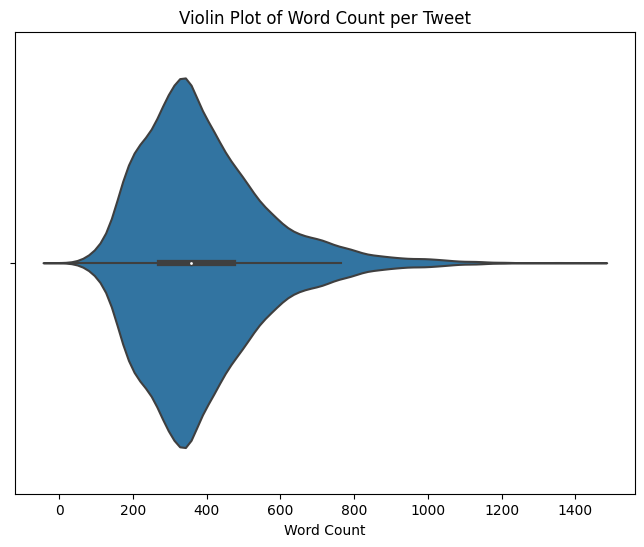

In [26]:
train_merged['word_count'] = train_merged['text'].apply(lambda x: len(str(x).split()))

# Calculate the statistics
plt.figure(figsize=(8, 6))
sns.violinplot(x=train_merged['word_count'])
plt.title('Violin Plot of Word Count per Tweet')
plt.xlabel('Word Count')
plt.show()

In [27]:
train_merged = train_merged.drop('word_count', axis = 1)

In [28]:
train_merged.head()

,text,generated
0,The Importance of the Electoral College in Pre...,1
1,The author did not do a good job supporting th...,0
2,The advantages of limiting car usage is incred...,0
3,Luke wants to convince you to become a seagoin...,0
4,"The author of ""The Challenge of Exploring Venu...",0


In [29]:
print("Training labels distribution:", np.bincount(train_merged['generated']))

Training labels distribution: [9178 5822]


## Balacing the data labels here: 

In [30]:
import pandas as pd
from sklearn.utils import resample

# Assuming 'train_merged' is your DataFrame and 'generated' is the label column
majority_class = train_merged[train_merged['generated'] == 0]
minority_class = train_merged[train_merged['generated'] == 1]

In [31]:
# Downsample the majority class
majority_downsampled = resample(majority_class,
                                replace=False,  # Sample without replacement
                                n_samples=len(minority_class),  # Match the number of minority class
                                random_state=42)  # For reproducibility

In [32]:
train_merged = pd.concat([majority_downsampled, minority_class])

In [33]:
print("Training labels distribution:", np.bincount(train_merged['generated']))

Training labels distribution: [5822 5822]


# What would be the steps here? (Distilbert)
- tokenizing words and sentences in the dataset 
- fine tuning the transformer model Distilbert. 

In [34]:
from sklearn.model_selection import train_test_split

# First, split into train+val and test
train_val_df, test_df = train_test_split(train_merged, test_size=0.1, random_state=42, stratify=train_merged['generated'])

# Now, split the train+val into train and validation
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42, stratify=train_val_df['generated'])

# Print the sizes of the splits to verify
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 9431
Validation set size: 1048
Test set size: 1165


In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=512)

In [ ]:
# Convert encodings and labels into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df['generated'].tolist()))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_df['generated'].tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df['generated'].tolist()))

# Batch the datasets
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(8)
val_dataset = val_dataset.batch(16)
test_dataset = test_dataset.batch(16)


In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

# Compile the model
class DistilBertWithDropout(tf.keras.Model):
    def __init__(self, base_model, num_labels, dropout_rate=0.3):
        super(DistilBertWithDropout, self).__init__()
        self.base_model = base_model  # Assign the base_model correctly
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, inputs, training=False):
        outputs = self.base_model(inputs)
        
        if len(outputs[0].shape) == 3:
            # Assume the output is [batch_size, sequence_length, hidden_size]
            pooled_output = outputs[0][:, 0, :]  # Extract the [CLS] token's output
        elif len(outputs[0].shape) == 2:
            # Assume the output is [batch_size, hidden_size] directly
            pooled_output = outputs[0]
        else:
            raise ValueError("Unexpected output shape from the base model.")
        
        dropout_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(dropout_output)
        return logits

# Instantiate the model
num_labels = 2  # Adjust this depending on your number of classes
dropout_rate = 0.3  # You can adjust the dropout rate
model = DistilBertWithDropout(model, num_labels, dropout_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model", save_best_only=True, save_format='tf')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
# Train the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=4,  # You can set this to a higher number
    callbacks=[checkpoint_cb, early_stopping_cb]
)

In [ ]:
# Retrieve a list of accuracy results on training and validation data
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of loss results on training and validation data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [ ]:
# Make predictions on the test set
y_pred = model.predict(test_dataset)

# Since the model outputs logits, convert these to predicted class labels
y_pred_labels = tf.argmax(y_pred, axis=1)


In [ ]:
# Extract true labels from the test set
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy())

# Convert to a TensorFlow tensor for compatibility
y_true = tf.convert_to_tensor(y_true)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Manually define the class labels if not available in the model config
class_labels = ['negative', 'positive']  # Replace with your actual class names

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Save the custom model
model.save('./AI-detector', save_format='tf')

# Save the tokenizer
tokenizer.save_pretrained('./AI-detector-tokenizer')


In [ ]:
loaded_model = tf.keras.models.load_model('./AI-detector')

loaded_tokenizer = DistilBertTokenizer.from_pretrained('./AI-detector-tokenizer')

## Finished implementing the DIstilbert model here.
<p style="font-size: 18px;">
    I have saved the model for the future use, so i no longer have to go through the same process again and i will just call the fine tuned model.
    </p> 

<h1 style="font-size: 30px;">
    It's time to implement another model:
</h1>
<p style="font-size: 16px;">
    For this task, I want to implement the model BLSTM.<br>
    I will use the same train, test, and validation set for this approach, then I will use the Stack method<br>
    for the final prediction.<br>
    For more detail, you can visit this website: 
    <a href="https://arxiv.org/abs/1909.01144" style="text-decoration: none;">
        BLSTM model
    </a>
</p>


In [35]:
train_df.shape

(9431, 2)

In [36]:
y_train = train_df['generated'].values

In [37]:
from gensim.models import Word2Vec

Embedding_dimensions = 150

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), train_df['text']))

In [38]:
# Defining the model and training it.
word2vec_model = Word2Vec(
    sentences=Word2vec_train_data,  # The tokenized training data
    vector_size=Embedding_dimensions,  # Size of the embedding vectors
    window=5,  # Maximum distance between the current and predicted word within a sentence
    min_count=5,  # Ignores all words with total frequency lower than this
    workers=8,  # Number of CPU cores to use for training
    sg=0  # Use Skip-Gram model (sg=1), or CBOW model (sg=0)
)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 19593


In [39]:
input_length = 512

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
vocab_length = 20000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(train_df['text'])
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 20000


In [41]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(test_df['text']) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (9431, 512)
X_test.shape : (1165, 512)


In [42]:
filtered_word_index = {word: token for word, token in tokenizer.word_index.items() if token <= vocab_length}

In [43]:
embedding_matrix = np.zeros((vocab_length , Embedding_dimensions))

for word, token in filtered_word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[token] = word2vec_model.wv[word]

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (20000, 150)


In [44]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [45]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [46]:
training_model = getModel()
training_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Sentiment_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [48]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
history = training_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=10,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8035 - loss: 0.4372 - val_accuracy: 0.9619 - val_loss: 0.1067 - learning_rate: 0.0010
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9466 - loss: 0.1487 - val_accuracy: 0.9682 - val_loss: 0.1010 - learning_rate: 0.0010
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9634 - loss: 0.1044 - val_accuracy: 0.9640 - val_loss: 0.0987 - learning_rate: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9613 - loss: 0.0991 - val_accuracy: 0.9841 - val_loss: 0.0500 - learning_rate: 0.0010
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9781 - loss: 0.0611 - val_accuracy: 0.9756 - val_loss: 0.0683 - learning_rate: 0.0010
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9808 - loss: 0.0549 - val_accuracy: 0.9852 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9784 - loss: 0.0607 - val_accuracy: 

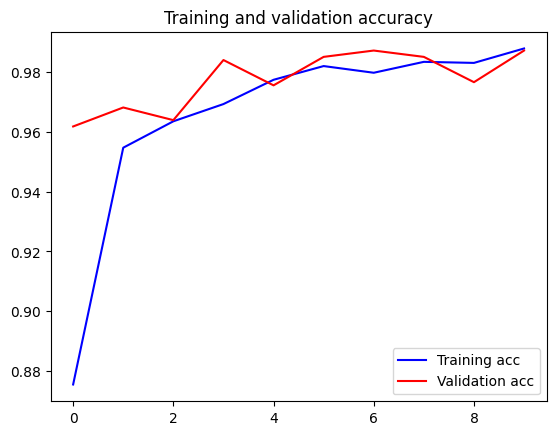

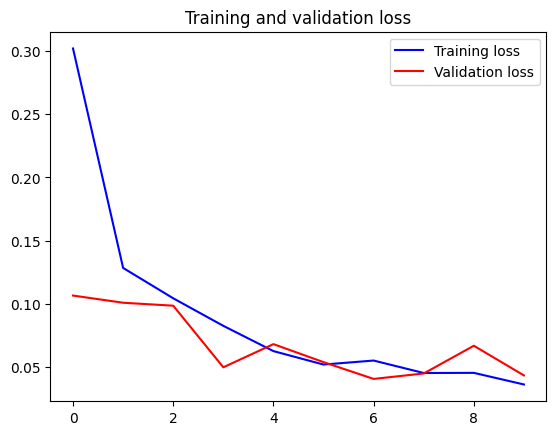

In [50]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 506ms/step
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       583
    Positive       0.99      0.98      0.99       582

    accuracy                           0.99      1165
   macro avg       0.99      0.99      0.99      1165
weighted avg       0.99      0.99      0.99      1165



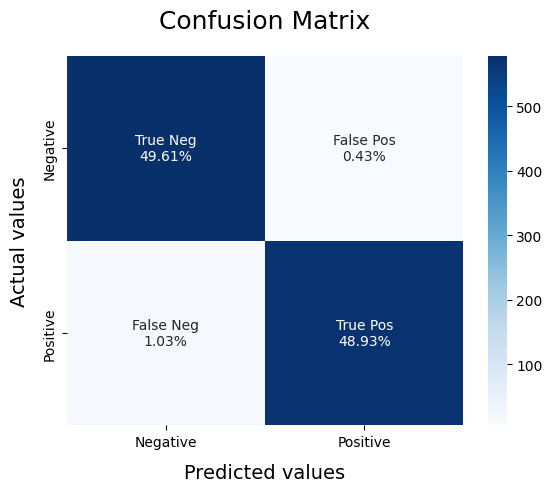

In [54]:
X_test = test_df['text']
y_test = test_df['generated']

# Tokenize and pad the test data
X_test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)

# Make predictions on the test data
y_pred = training_model.predict(X_test_sequences)

# Convert prediction probabilities to binary outcomes (0 or 1)
y_pred = np.where(y_pred >= 0.5, 1, 0)

# Print the confusion matrix
ConfusionMatrix(y_pred, y_test)

# Additionally, print the classification report for detailed metrics
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

In [56]:
# Save the BiLSTM model
training_model.save('saved_bilstm_model.keras')

# Save the Word2Vec model
word2vec_model.save('word2vec_model.model')


In [60]:
from tensorflow.keras.models import load_model
loaded_bilstm_model = load_model('saved_bilstm_model.keras')
loaded_word2vec_model = Word2Vec.load('word2vec_model.model')

### loading the model was succecful

## Done training the BLSTM model here. 
- now all i got to do is to use the stack method for final prediction.

In [ ]:
test_essay = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

In [ ]:
test_essay.head()

In [ ]:
test_encodings = tokenizer(test_essay['text'].tolist(), truncation=True, padding=True, max_length=512)

In [ ]:
# Create the TensorFlow dataset only for these 3 entries
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(8)


# Make predictions using the model
predictions = model.predict(test_dataset)

# Convert logits to probabilities using softmax
prediction_probabilities = tf.nn.softmax(predictions.logits, axis=-1).numpy()

# Extract the probability of the positive class
positive_class_probs = prediction_probabilities[:, 1]

In [ ]:
print(f"Length of test_essay['id']: {len(test_essay['id'])}")
print(f"Length of positive_class_probs: {len(positive_class_probs)}")


In [ ]:
results_df = pd.DataFrame({
    'id': test_essay['id'],
    'generated': positive_class_probs
})

# Save the results to a CSV file
results_df.to_csv('submission.csv', index=False)


In [ ]:
print(results_df)